# Auswertung Elektrische Leitfähigkeitsrelaxation

Zunächst müssen einige relevante Packete und Funktionen importiert werden.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy.optimize import curve_fit, fsolve
from sympy import Symbol, lambdify, tan

Daten der Probe. **Werte hier anpassen!**

In [2]:
d = 1.13  # thickness in cm
I = 0.01  # current in A
a = 0.417/2  # sample width in cm
A = (2*a) ** 2 # area in cm^2

Import der Daten aus der Textdatei (**Dateinamen anpassen!**).

Hier muss darauf geachtet werden, dass die Spalten in der richtigen Reihenfolge angegeben sind und dass letzte Zeile in der Datei vollständig ist. Wenn nicht, können Fehler auftreten.<br>
**Der Wert von 'skiprows' muss angepassst werden**, bis alle Werte vor dem Sprung entfernt sind (kann im Plot überprüft werden).

In [3]:
ecr_data = pd.read_csv(
    "Gruppe_34.txt", 
    names = [
        "Zeit [s]", 
        "Spannung Keramik [V]", 
        "Spannung O2-Sensor [V]", 
        "Temperatur [°C]", 
        "Gaszufluss N2 [mL/min]", 
        "Gaszufluss O2 [mL/min]"
        ],
    delim_whitespace=True,
    skiprows=50
)
ecr_data["Zeit [s]"] = ecr_data["Zeit [s]"] - ecr_data["Zeit [s]"][0]  # Let the time column start with 0

Die Daten aus der Datei sind jetzt als Dataframe gespeichert. Eine Übersicht über das Dataframe ist durch EIngabe des Namens möglich:

In [4]:
ecr_data

Zeit [s]  Spannung Keramik [V]  Spannung O2-Sensor [V]  Temperatur [°C]  \
0           0              0.002045                0.023388              800   
1           4              0.002044                0.013464              800   
2           7              0.002043                0.016480              800   
3          11              0.002042                0.026947              800   
4          15              0.002042                0.031895              800   
..        ...                   ...                     ...              ...   
909      3331              0.001902                0.022651              800   
910      3335              0.001901                0.013049              800   
911      3338              0.001900                0.030014              800   
912      3342              0.001901                0.020190              800   
913      3345              0.001900                0.030288              800   

     Gaszufluss N2 [mL/min]  Gaszufluss O2 [mL/min]  
0                         0                     100  
1                         0                     100  
2                         0                     100  
3                         0                     100  
4                         0                     100  
..                      ...                     ...  
909                       0                     100  
910                       0                     100  
911                       0                     100  
912                       0                     100  
913                       0                     100  

[914 rows x 6 columns]

Berechnung der Leitfähigkeit in S/cm (wird als neue Spalte in das Dataframe eingefügt).

Plotten der Leitfähigkeit.

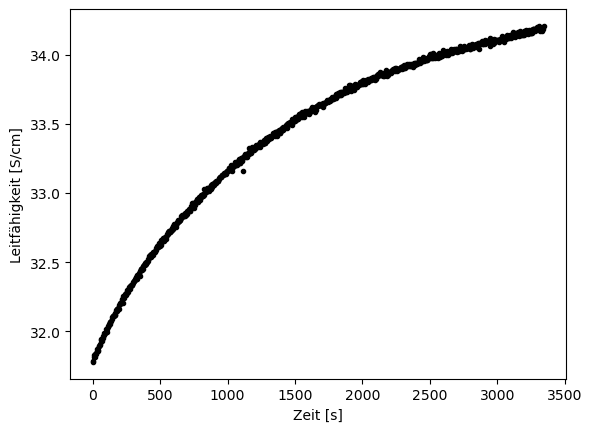

In [5]:
ecr_data["Leitfähigkeit [S/cm]"] = d*I/(A*ecr_data["Spannung Keramik [V]"])

ecr_data.plot(
    "Zeit [s]",
    "Leitfähigkeit [S/cm]",
    legend=False,  # no legend in the plot
    ylabel="Leitfähigkeit [S/cm]",  # label of y axis
    style="k."  # k = black color; . = points as symbols
)
plt.savefig("plot1.pdf", bbox_inches='tight')

Berechnung der normierten Leitfähigkeit.
Plotten der normierten Leitfähigkeit.

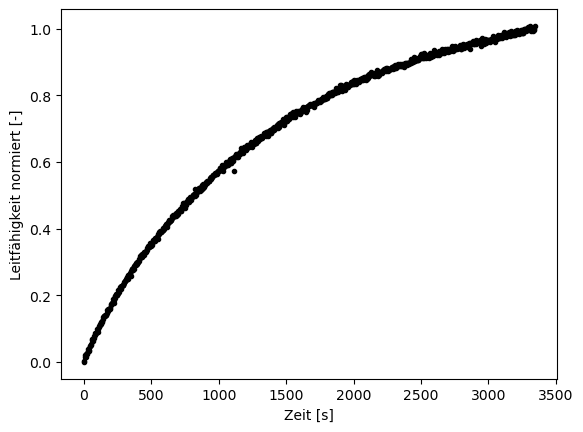

In [6]:
ecr_data["Leitfähigkeit normiert [-]"] = (ecr_data["Leitfähigkeit [S/cm]"] - ecr_data["Leitfähigkeit [S/cm]"][0]) / (ecr_data["Leitfähigkeit [S/cm]"].iloc[-10:-1].mean() - ecr_data["Leitfähigkeit [S/cm]"][0])

ecr_data.plot(
    "Zeit [s]",
    "Leitfähigkeit normiert [-]",
    legend=False,
    ylabel="Leitfähigkeit normiert [-]",
    style="k."
)
plt.savefig("plot2.pdf", bbox_inches='tight')

Startwerte für den Fit. **$L_a$ und $\tilde{k}$ hier anpassen!**

Hinweis: Die Werte werden hier nicht direkt als Variablen gespeichert (so wie oben die Daten der Probe gespeichert wurden), sondern als dictionary. Das hat den Vorteil, dass man sich nicht so schnell mit den Werten der verschiedenen Iterationen vertun kann.

In [7]:
initial_values = {
    "La": 2,  # dimensionless
    "k": 1e-4,  # in cm/s
}

Berechnung von $\tilde{D}$ aus den oben gegebenen Werten.

In [8]:
initial_values["D"] = (a/2) * (initial_values["k"]/initial_values["La"])
print(f'D [cm^2/s] = {initial_values["D"]:.5e}')

D [cm^2/s] = 5.21250e-06


Numerische Berechnung von $β$ aus den oben gegeben Werten.

In [9]:
beta_guess = 0.8
beta_symbol = Symbol('b')
func = lambdify(beta_symbol, beta_symbol*tan(beta_symbol)-initial_values["La"])
initial_values["beta"] = fsolve(func, beta_guess)[0]
print(f'β = {initial_values["beta"]:.3f}')

β = 1.077


Definition der Formel, die gefittet werden soll.

In [10]:
def fit_formula(t, a, k, D, beta):
    return 1-(2*(a*k/D)**2*np.exp(-beta**2*D*t/a**2)/(beta**2*(beta**2+(a*k/D)**2+(a*k/D))))**2

Erste Iteration des Fits.
Hier wird eine modifizierte Version der zuvor definierten Formel genutzt, damit nur $k$ und $\tilde{D}$ gefittet werden.

In [11]:
fit_formula_fixed_ab = lambda t, k, D: fit_formula(t, a, k, D, initial_values["beta"])

popt1, pcov1 = curve_fit(
    f=fit_formula_fixed_ab,
    xdata=ecr_data["Zeit [s]"],
    ydata=ecr_data["Leitfähigkeit normiert [-]"],
    p0=(initial_values["k"], initial_values["D"]),
    method="lm"
)
perr1 = np.sqrt(np.diag(pcov1))

print(f"k [cm/s] = {popt1[0]:.5e} ± {perr1[0]:.5e}")
print(f"D [cm^2/s] = {popt1[1]:.5e} ± {perr1[1]:.5e}")

k [cm/s] = 1.75350e-04 ± 9.21746e-07
D [cm^2/s] = 1.70009e-05 ± 5.96835e-08


Plotten der Fitergebnisse.

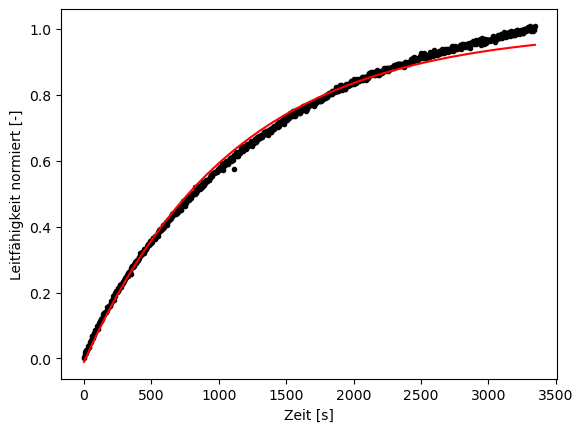

In [12]:
plt.xlabel("Zeit [s]")
plt.ylabel("Leitfähigkeit normiert [-]")
plt.plot(ecr_data["Zeit [s]"], ecr_data["Leitfähigkeit normiert [-]"], 'k.')
plt.plot(ecr_data["Zeit [s]"], fit_formula_fixed_ab(ecr_data["Zeit [s]"], *popt1), 'r-')
plt.savefig("plot3.pdf", bbox_inches='tight')

Berechnung eines neuen Werts für $L_a$ aus den Daten der ersten Iteration des Fits.

In [13]:
first_iteration_values = {
    "La": a/2 * popt1[0] / popt1[1],
    "k": popt1[0],
    "D": popt1[1]
}
print(f'La = {first_iteration_values["La"]:.3f}')

La = 1.075


Numerische Approximation (mit scipy) eines neuen Werts für $β$.

In [14]:
func = lambdify(beta_symbol, beta_symbol*tan(beta_symbol)-first_iteration_values["La"])
first_iteration_values["beta"] = fsolve(func, beta_guess)[0]
print(f'β = {first_iteration_values["beta"]:.3f}')

β = 0.883


Zweite Iteration des Fits. Als Startwerte werden die Fitergebnisse aus dem ersten Fit genutzt.

In [15]:
fit_formula_fixed_ab_2 = lambda t, k, D: fit_formula(t, a, k, D, first_iteration_values["beta"])

popt2, pcov2 = curve_fit(
    f=fit_formula_fixed_ab_2,
    xdata=ecr_data["Zeit [s]"],
    ydata=ecr_data["Leitfähigkeit normiert [-]"],
    p0=popt1,
    method="lm"
)
perr2 = np.sqrt(np.diag(pcov2))

print(f"k [cm/s] = {popt2[0]:.5e} ± {perr2[0]:.5e}")
print(f"D [cm^2/s] = {popt2[1]:.5e} ± {perr2[1]:.5e}")

k [cm/s] = 1.33521e-04 ± 6.16501e-07
D [cm^2/s] = 2.52765e-05 ± 8.87356e-08


Plotten der Fitergebnisse.

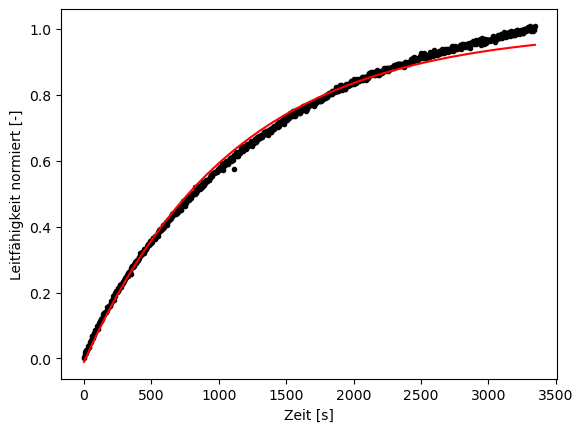

In [16]:
plt.xlabel("Zeit [s]")
plt.ylabel("Leitfähigkeit normiert [-]")
plt.plot(ecr_data["Zeit [s]"], ecr_data["Leitfähigkeit normiert [-]"], 'k.')
plt.plot(ecr_data["Zeit [s]"], fit_formula_fixed_ab_2(ecr_data["Zeit [s]"], *popt2), 'r-')
plt.savefig("plot4.pdf", bbox_inches='tight')

In [17]:
second_iteration_values = {
    "La": a/2 * popt2[0] / popt2[1],
    "k": popt2[0],
    "D": popt2[1]
}

Berechnung von $L_{\rm C}$ zum Vergleich mit den Probenabmessungen.

In [18]:
Lc=second_iteration_values["D"]/second_iteration_values["k"]
print(f"LC [mm] = {10*Lc:.3f}")

LC [mm] = 1.893


Zusammenfassende Ausgabe der Daten.

In [19]:
print("Startwerte:", initial_values)
print("Erste Iteration:", first_iteration_values)
print("Zweite Iteration:", second_iteration_values)

Startwerte: {'La': 2, 'k': 0.0001, 'D': 5.2125e-06, 'beta': 1.0768739863118038}
Erste Iteration: {'La': 1.0752511754788683, 'k': 0.00017535016413257435, 'D': 1.7000915718766524e-05, 'beta': 0.8831668338301978}
Zweite Iteration: {'La': 0.5506911638403654, 'k': 0.00013352072229491508, 'D': 2.5276482016115837e-05}
